In [1]:
from pathlib import Path
import os
import re
import datetime
import warnings
from shutil import copyfile
from dataclasses import dataclass
import json
import pandas as pd
import numpy as np

BACKUP_DIR = Path("./backups")
UPOWER_BACKUP_DIR = BACKUP_DIR / "upower"



In [2]:
json_file_names = os.listdir(UPOWER_BACKUP_DIR)
data = []
for filename in json_file_names:
    with open(UPOWER_BACKUP_DIR / filename, "r", encoding="utf8") as f:
        data.append(json.load(f))
len(json_file_names)
df = pd.DataFrame(data).sort_values("created_utc")
df['date'] = df['created_utc'].transform(datetime.datetime.fromtimestamp)
df.sort_values("created_utc").iloc[-1]['date']

Timestamp('2024-02-05 22:12:08')

<AxesSubplot:xlabel='created_utc'>

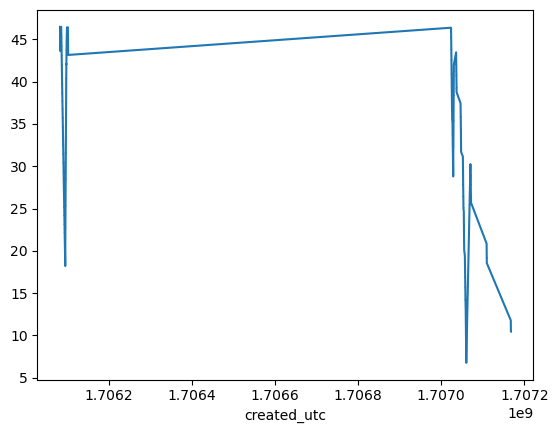

In [3]:
df.set_index("created_utc")['energy'].plot()

<AxesSubplot:xlabel='created_utc'>

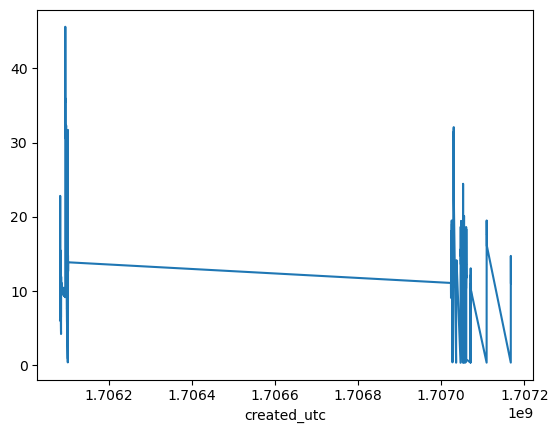

In [4]:
df.set_index("created_utc")['energy_rate'].plot()

In [5]:
df['created_utc'].sort_values()

1661    1706082448
945     1706082508
2551    1706082568
1796    1706082629
1136    1706082689
           ...    
2655    1707167488
2305    1707167498
3341    1707167508
1337    1707167518
5       1707167528
Name: created_utc, Length: 3539, dtype: int64

In [6]:
import datetime

Period from '2024-02-04 09:31:36' (1707035496) to '2024-02-05 22:12:08'


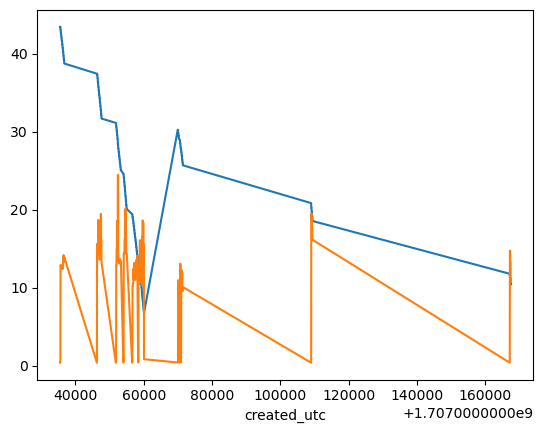

In [7]:
data = [
    {
        "description": "Discharge at constant power consumption. (No work done at pc)",
        "min_ts": 1706085300,
        "max_ts": 1706094734,
    },
    {
        "description": "Zugfahrt Basel - Zuerich, kein Docker Container und kein Notebook am laufen",
        "min_ts": 1707023500,
        "max_ts": 1707026694,
    },
    {
        "description": "Zugfahrt Basel - Zuerich, kein Docker Container und kein Notebook am laufen",
        "min_ts": 1707034000,
        "max_ts": 1709026694,
    }
]

idx = 2

min_ts = data[idx]['min_ts']
max_ts = data[idx]['max_ts']

check_df = df.loc[(df['created_utc'] >= min_ts) & (df['created_utc'] <= max_ts)]

check_df.set_index("created_utc")['energy'].plot()
check_df.set_index("created_utc")['energy_rate'].plot()


print(f"Period from '{datetime.datetime.fromtimestamp(check_df['created_utc'].min())}' ({check_df['created_utc'].min()}) to"
      f" '{datetime.datetime.fromtimestamp(check_df['created_utc'].max())}'")

In [8]:
34000+1.70700e9

1707034000.0

In [9]:
from sklearn.linear_model import LinearRegression
import numpy as np
model = LinearRegression()

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [269]:
y = check_df.set_index("created_utc")['energy']
x = np.array(check_df['created_utc']).reshape((-1, 1))
model = model.fit(x, y)
model.coef_

array([-0.00290983])